# Here we present *MALDIpy*, a Python-based package for analyzing MALDI-MS imaging mass spectrometry data, including species visualization, single-cell analysis with UMAP clustering and projection of cell type annotations.

* ## In this notebook, we demonstrate how we can use *MALDIpy* to analyze one single dataset with high efficiency -- all analysis can be done in 5-10 minutes on a labtop.

In [1]:
import pandas as pd
import scanpy as sc
import scanpy.external as sce
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100, facecolor='white',fontsize=12)
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager
import matplotlib.font_manager as fm

In [2]:
import MALDIpy
from MALDIpy import *
from MALDIpy.msi_data import msi_data

## First, read the imaging mass spectrometry data, a csv file that can be downloaded from the METASPACE platform.

In [3]:
raw_file = pd.read_csv('pixel_data_normed/FDR20/23-0179-haikuo_li-flex-patient3-cortex_pixel_intensities_tic_normalized.csv',sep=',',skiprows=2)

## The function *msi_data* allows you to create a MALDIpy object which we will start with.

In [4]:
maldi_obj = msi_data(raw_file,scale=10)

## You can visualize any metabolite of interest with it raw m/z value using the function *plt*.
* Here we are visualizing m/z 741.530654593237, a glomerulus-specific species in the human kidney.

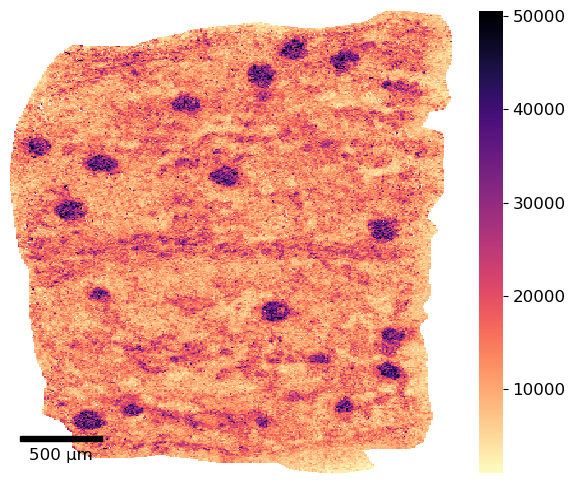

In [5]:
maldi_obj.plt(mz=741.530654593237, figsize = (6,5), smooth=False, pos = 'lower left', 
                   remove_hs = True, cmap = "magma_r", dpi = 100)

## For single-cell analysis, we provide a function called *to_adata*, which can generate an AnnData object from a MALDIpy object.
* Such AnnData object can be processed with [Scanpy](https://scanpy.readthedocs.io/en/stable/index.html), a single-cell analysis tool in Python.

In [6]:
adata = maldi_obj.to_adata(add_meta=True, csv_file=raw_file)

## To simply the Scanpy workflow, we provide three functions, (1) *single_cell.maldifilter*, (2) *single_cell.maldi_norm* and (3) *single_cell.maldi_clustering*, for data filtering/QC, normalization/regress_out/scale and dimension reduction/UMAP/Leiden clustering, respectively.

In [7]:
MALDIpy.single_cell.maldifilter(adata, min_count=40000, min_gene=30)

filtered out 16479 cells that have less than 40000 counts
filtered out 132 cells that have less than 30 genes expressed


AnnData object with n_obs × n_vars = 89375 × 376
    obs: 'n_genes_by_counts', 'total_counts', 'n_counts', 'n_genes'
    var: 'mz_raw', 'mol_formula', 'adduct', 'moleculeNames', 'moleculeIds', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [8]:
MALDIpy.single_cell.maldi_norm(adata, regress_out_key='total_counts')

normalizing counts per cell
    finished (0:00:00)
regressing out ['total_counts']
/home/users/hli/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'adduct' as categorical
/home/users/hli/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'moleculeNames' as categorical
/home/users/hli/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Catego

AnnData object with n_obs × n_vars = 89375 × 376
    obs: 'n_genes_by_counts', 'total_counts', 'n_counts', 'n_genes'
    var: 'mz_raw', 'mol_formula', 'adduct', 'moleculeNames', 'moleculeIds', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

* The use of Harmony is important if we are integrating multiple MALDI-MS data. We do not perform Harmony integration in this example (*use_harmony=False*) since we are only processing one sample.

In [9]:
MALDIpy.single_cell.maldi_clustering(adata, use_harmony=False, n_neighbor=30, n_pc=30, umap_min_dist=0.2,
                                    leiden_res=1, leiden_key_added='leiden')

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:18)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:35)
running Leiden clustering
    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:02:38)


AnnData object with n_obs × n_vars = 89375 × 376
    obs: 'n_genes_by_counts', 'total_counts', 'n_counts', 'n_genes', 'leiden'
    var: 'mz_raw', 'mol_formula', 'adduct', 'moleculeNames', 'moleculeIds', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

## We can visualize the Leiden clustering result on the UMAP space.

/home/users/hli/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'leiden' as categorical


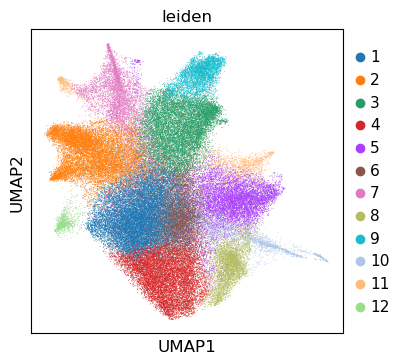

In [10]:
sc.pl.umap(adata, color=['leiden'])

## Here we are checking two glomerulus-specific metabolites.
* You can find they are mainly present in Leiden cluster 9.

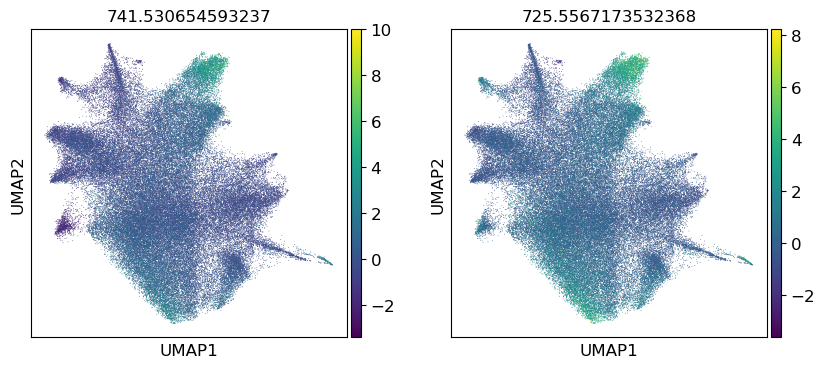

In [11]:
sc.pl.umap(adata, color=['741.530654593237','725.5567173532368'])

## In many cases we describe a metabolite based on its formula instead of the exact m/z value. If needed, we could check the corresponding formula and set the formula as the AnnData var.index.

In [12]:
idx1=list(adata.var.mz_raw).index('741.530654593237')
idx2=list(adata.var.mz_raw).index('725.5567173532368')
print([adata.var.mol_formula[idx1],adata.var.mol_formula[idx2]])

['C39H79N2O6PK', 'C39H79N2O6PNa']


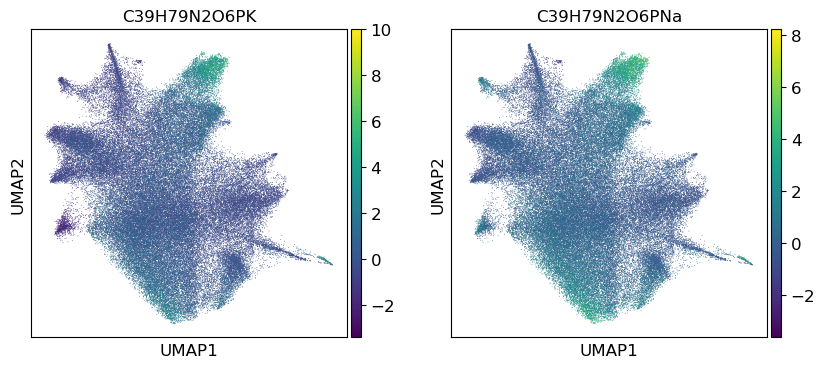

In [13]:
adata.var.index=adata.var.mol_formula
sc.pl.umap(adata, color=[adata.var.mol_formula[idx1],adata.var.mol_formula[idx2]])

## A key feature of this package is to project your single-cell cluster annotations onto the tissue plot. To do this, use the function *projection.umap_projection*.
* You can see Leiden cluster 9 presents a kidney glomerulus distribution pattern, consistent with our expectation.

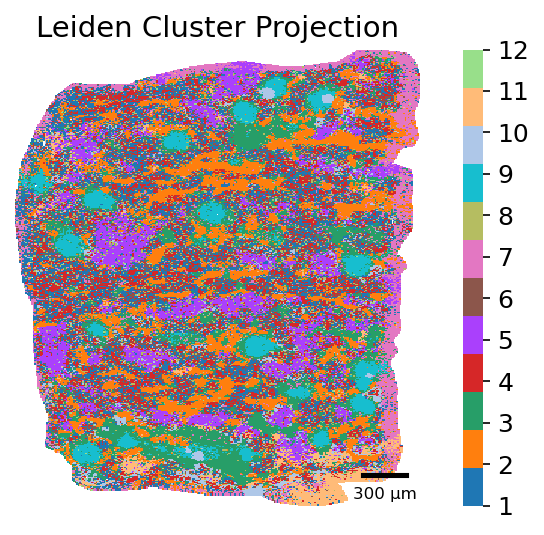

In [14]:
MALDIpy.projection.umap_projection(adata, file_name=raw_file,
                                   pltcmap=adata.uns['leiden_colors'],
                                   figtitle='Leiden Cluster Projection',figdpi=150, fig_size=(4,4),
                                   add_scalebar=True)

## (Optional) More analysis can be done with the standard Scanpy pipeline, such as marker feature finding and visualization on a dotplot. We present an example below. 

In [15]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon',key_added='rank_genes_groups_leiden')

ranking genes
/home/users/hli/anaconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/users/hli/anaconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/users/hli/anaconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/users/hli/anaconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/users/hli/anaconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.lo

In [19]:
marker_genes=[]
for i in range(len(set(adata.obs['leiden']))):
    marker_genes.append(adata.uns['rank_genes_groups_leiden']['names'][str(i+1)][0])
    marker_genes.append(adata.uns['rank_genes_groups_leiden']['names'][str(i+1)][1])

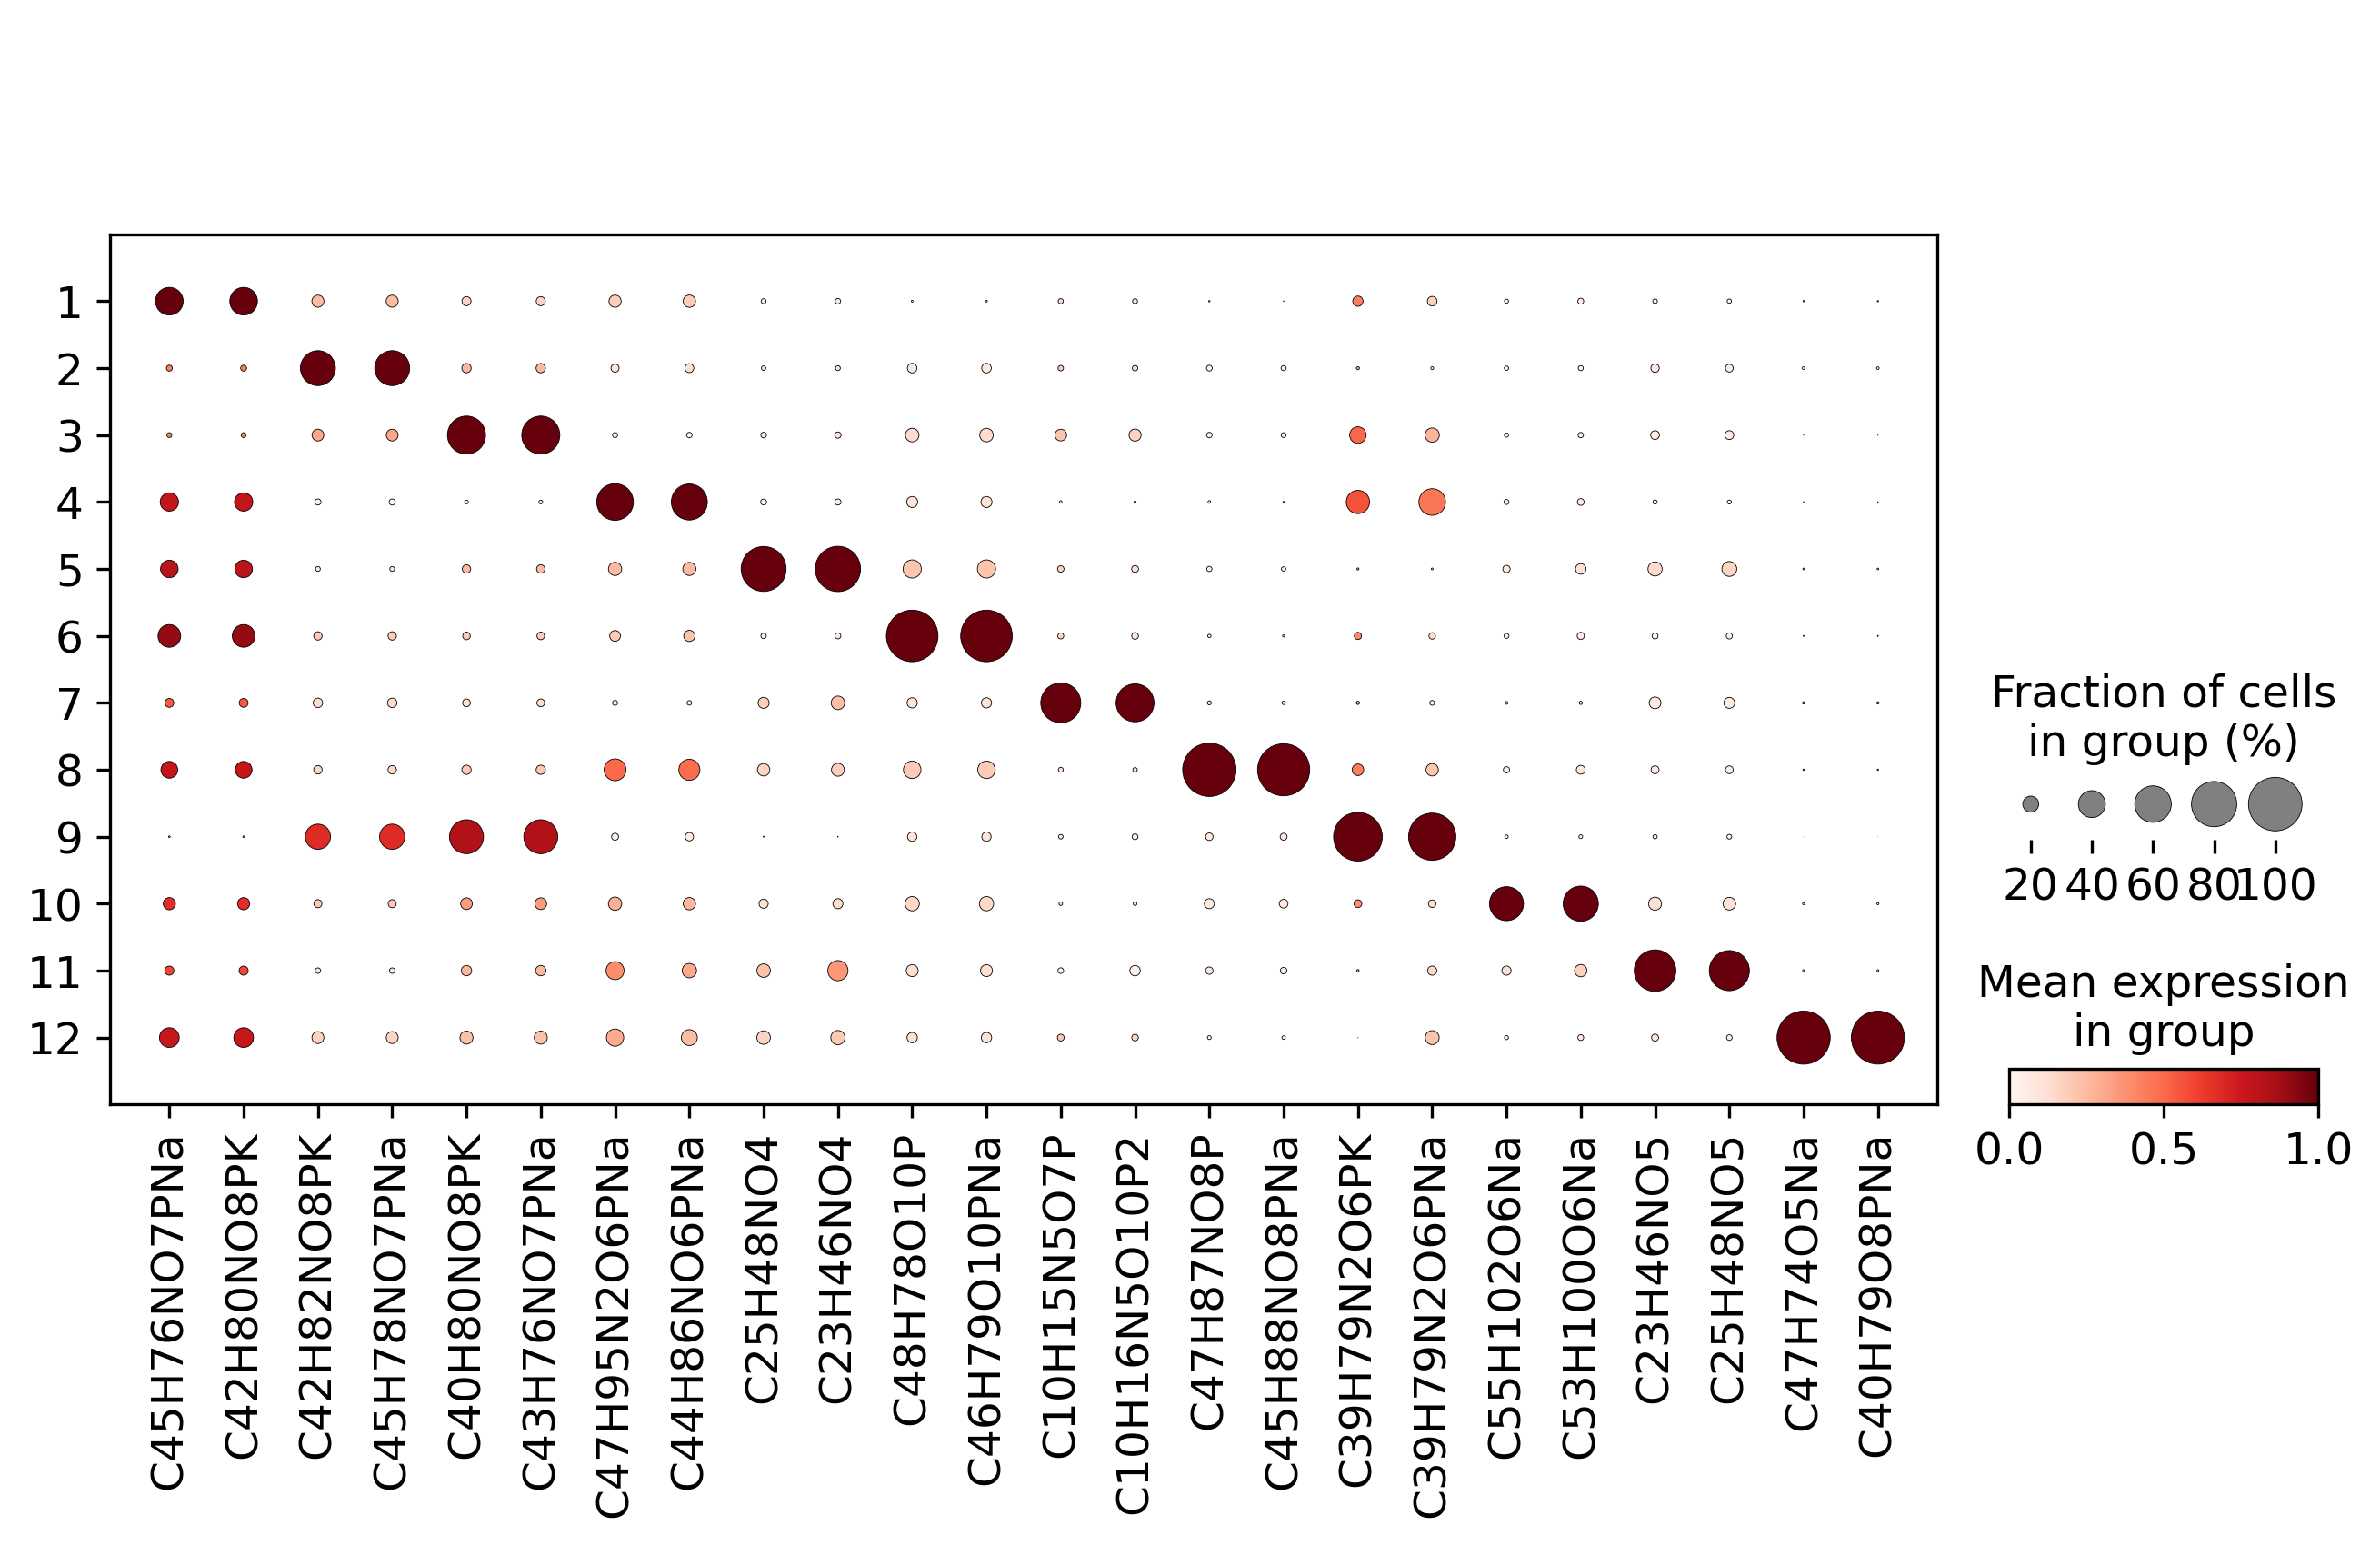

In [33]:
sc.settings.set_figure_params(dpi=300, facecolor='white',fontsize=14)
    
sc.pl.dotplot(adata, marker_genes, groupby='leiden',
             standard_scale='var',cmap='Reds',expression_cutoff=0.8)